<!--<badge>--><a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group06/blob/main/Assignments/02-vanillaCNN_UCM/02-CNN_UCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from zipfile import ZipFile
#import wget
import requests
import shutil

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


In [52]:
dataset_url = 'http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip'

train_percentage = 0.7
test_percentage = 0.2
valid_percentage = 0.1

try:
    with open('UCMerced_LandUse.zip', 'xb') as dataset_zip:
        r = requests.get(dataset_url, stream=True)
        total_length = int(r.headers.get('content-length'))
        sofar = 0
        last_percentage = -1
        print('Downloading:')
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                dataset_zip.write(chunk)
                sofar += len(chunk)
                percentage = (((sofar / total_length) * 100) // 5) * 5
                if percentage != last_percentage:
                    print(f'{percentage}%', end=' ')
                    last_percentage = percentage
except FileExistsError:
    print('Data is already there skipping downloading, delete zip file if you think this is a mistake.')
    
    
with ZipFile('UCMerced_LandUse.zip', 'r') as data_zip:
    data_zip.extractall('./') # extract zip to current dir

try:
    shutil.rmtree('archive')
except FileNotFoundError:
    pass

os.mkdir('archive')
os.mkdir('archive/images_train_test_val')
os.mkdir('archive/images_train_test_val/train')
os.mkdir('archive/images_train_test_val/validation')
os.mkdir('archive/images_train_test_val/test')

classes = os.listdir('UCMerced_LandUse/Images')

def copy_tiff_as_png(tiff_path, copy_path):
    for root, dirs, files in os.walk(tiff_path, topdown=False):
        root_paths = set()
        for name in files:
            #print(os.path.join(root, name), name, dirs)
            rel_root_path = os.path.relpath(root, tiff_path)
            if rel_root_path not in root_paths:
                os.mkdir(os.path.join(copy_path, rel_root_path))
                root_paths.add(rel_root_path)
            new_path = os.path.join(copy_path, rel_root_path, name)
            try:
                outfile = os.path.splitext(new_path)[0] + ".png"
                im = Image.open(os.path.join(root, name))
                im.thumbnail(im.size)
                im.save(outfile, "png")
            except Exception as e:
                print (e)

print('converting and copying files to png, it takes around 1 minutes')
copy_tiff_as_png('UCMerced_LandUse/Images', 'archive/images_train_test_val/train')
print('splitting train/test/validation set')
trpc,tepc, vpc = 70, 20, 10
for cls in classes:
    os.mkdir(f'archive/images_train_test_val/validation/{cls}')
    os.mkdir(f'archive/images_train_test_val/test/{cls}')
    files = os.listdir(f'archive/images_train_test_val/train/{cls}')
    shuffle = np.arange(100)
    np.random.shuffle(shuffle)
    for i in shuffle[:tepc]:
        filename = files[i]
        shutil.move(f'archive/images_train_test_val/train/{cls}/{filename}', f'archive/images_train_test_val/test/{cls}')
    for i in shuffle[tepc:tepc + vpc]:
        filename = files[i]
        shutil.move(f'archive/images_train_test_val/train/{cls}/{filename}', f'archive/images_train_test_val/validation/{cls}')
print('done')  

Data is already there skipping downloading, delete zip file if you think this is a mistake.
converting and copying files to png, it takes around 1 minutes
splitting train/test/validatin set
done


In [56]:
train_ds = tf.keras.utils.image_dataset_from_directory("archive/images_train_test_val/train")
val_ds = tf.keras.utils.image_dataset_from_directory("archive/images_train_test_val/validation")
test_ds = tf.keras.utils.image_dataset_from_directory("archive/images_train_test_val/test")

Found 1470 files belonging to 21 classes.
Found 210 files belonging to 21 classes.
Found 420 files belonging to 21 classes.


In [48]:
num_classes = train_ds.class_names
len(num_classes)

21

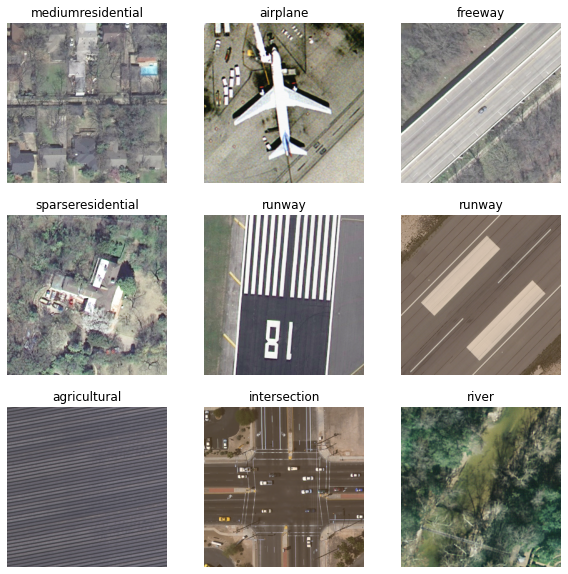

In [49]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(num_classes[labels[i]])
    plt.axis("off")


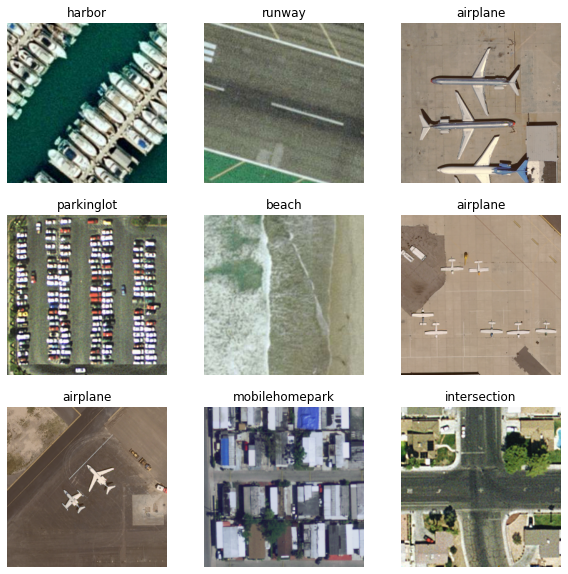

In [50]:

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(num_classes[labels[i]])
    plt.axis("off")


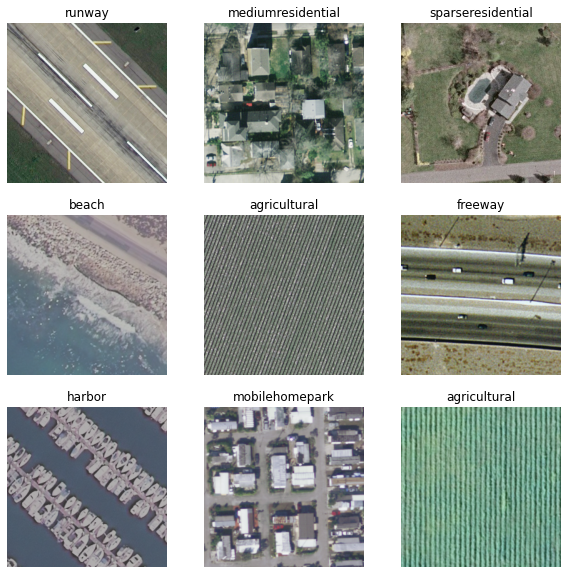

In [51]:

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(num_classes[labels[i]])
    plt.axis("off")


In [8]:
#Normalize the images
#train_ds = train_ds.map(lambda x, y: (x/255.0, y))
#val_ds = val_ds.map(lambda x, y: (x/255.0, y))
#test_ds = test_ds.map(lambda x, y: (x/255.0, y))


Model Training

In [53]:
model = Sequential()
#Add a rescaling layer
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(num_classes), activation='softmax'))


In [54]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=['accuracy'])


In [57]:
#Training time measurement
import time
start_time = time.time()
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)
end_time = time.time()
print("Training time: ", end_time - start_time)


Epoch 1/40


2022-07-18 22:05:23.699692: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-07-18 22:05:24.886486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.


 1/46 [..............................] - ETA: 1:56 - loss: 3.0425 - accuracy: 0.0625

2022-07-18 22:05:25.704824: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-07-18 22:05:26.930635: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.


 2/46 [>.............................] - ETA: 1:29 - loss: 3.1539 - accuracy: 0.0312

2022-07-18 22:05:27.703037: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.


46/46 [==============================] - 107s 2s/step - loss: 3.0410 - accuracy: 0.0558 - val_loss: 2.9606 - val_accuracy: 0.0810
Epoch 2/40
46/46 [==============================] - 114s 2s/step - loss: 2.8818 - accuracy: 0.1041 - val_loss: 2.7182 - val_accuracy: 0.2000
Epoch 3/40
46/46 [==============================] - 120s 3s/step - loss: 2.6392 - accuracy: 0.1769 - val_loss: 2.4827 - val_accuracy: 0.2524
Epoch 4/40
46/46 [==============================] - 126s 3s/step - loss: 2.3223 - accuracy: 0.2714 - val_loss: 2.1775 - val_accuracy: 0.3429
Epoch 5/40
46/46 [==============================] - 124s 3s/step - loss: 2.0092 - accuracy: 0.3537 - val_loss: 2.0365 - val_accuracy: 0.3667
Epoch 6/40
46/46 [==============================] - 111s 2s/step - loss: 1.7387 - accuracy: 0.4449 - val_loss: 1.9206 - val_accuracy: 0.3952
Epoch 7/40
46/46 [==============================] - 103s 2s/step - loss: 1.4885 - accuracy: 0.5122 - val_loss: 1.7468 - val_accuracy: 0.4810
Epoch 8/40
46/46 [======

KeyboardInterrupt: 

In [59]:

end_time = time.time()
print("Training time: ", end_time - start_time)

Training time:  1359.1890902519226


In [58]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        1

Test accuracy

In [60]:
model.evaluate(test_ds)

14/14 [==============================] - 6s 429ms/step - loss: 2.0729 - accuracy: 0.4452


[2.072902202606201, 0.4452380836009979]